# 📶 Análisis de Señales EMG en Python
---
Este notebook presenta el procesamiento y análisis de señales de electromiografía de superficie (sEMG)  durante distintos tipos de contracción: reposo, contracción voluntaria lenta y contracción contra resistencia. 

Se incluyen los pasos de preprocesamiento, filtrado, rectificación, cálculo de envolvente y densidad espectral de potencia (PSD), con visualización de resultados para cada registro.

## 📚 1. Importación de librerías
---
Se importan las librerías necesarias para la manipulación de datos, procesamiento de señales y visualización:

- **pandas:** para lectura y manejo de archivos de datos.
- **numpy:** para operaciones numéricas.
- **matplotlib.pyplot:** para visualización de gráficos.
- **scipy.signal:** para filtrado digital y análisis espectral.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, find_peaks 

## 📥 2. Lectura de la señal EMG
---
Se importa la señal registrada desde un archivo de texto, extrayendo únicamente el canal de interés (`O2`) correspondiente al bíceps braquial.  
Se definen además los parámetros del sensor, como el voltaje de referencia, la ganancia y la resolución del ADC.

In [21]:
# === 1. Leer archivo de EMG ===
ruta = r"C:\SeñalesLab3\Lento2Biceps.txt"
df = pd.read_csv(ruta, sep="\t", comment="#",
                 names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
# === 2. Extraer canal O2 ===
ADC = df["O2"].values
# === 3. Parámetros del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000  # Frecuencia de muestreo en Hz

## ⚡ 3. Conversión ADC a Voltaje y Centrado de Señal
---
Se convierte la señal del ADC a milivoltios y se elimina la componente DC para centrar la señal alrededor de 0 mV.

In [22]:
# === 4. Conversión ADC → mV ===
EMG_V = ((ADC / ADCres) - 0.5) * VCC / Gain
EMG_mV = EMG_V * 1000
# === 5. Quitar componente DC ===
EMG_noDC = EMG_mV - EMG_mV.mean()

## 🌀 4. Filtrado de la señal
---
Se aplica filtrado digital para mejorar la calidad de la señal:

1. **Filtro pasa-altas de 20 Hz:** elimina componentes de baja frecuencia y movimiento.
2. **Filtro notch 60 Hz y armónicos hasta 480 Hz:** reduce interferencia eléctrica de la red eléctrica.

In [23]:
# === 6. Filtro pasa-altas 20 Hz ===
fc = 20 # Frecuencia de corte en Hz
b, a = signal.butter(4, fc/(fs/2), btype='high') # Butterworth 4º orden
EMG_filtered = signal.filtfilt(b, a, EMG_noDC) # Filtrado sin desfase

# === 6b. Filtro notch 60 Hz y armónicos hasta 480 Hz ===
EMG_clean = EMG_filtered.copy()
Q = 30 # Factor de calidad para notch (estrecho)
for f_h in np.arange(60, 481, 60): # 60, 120, 180, ..., 480 Hz
    b_notch, a_notch = signal.iirnotch(f_h, Q, fs)
    EMG_clean = signal.filtfilt(b_notch, a_notch, EMG_clean) # Aplicar notch

## 📈 5. Visualización de la señal
---
Se muestran las señales cruda y preprocesada en gráficos lado a lado para cada tipo de contracción.

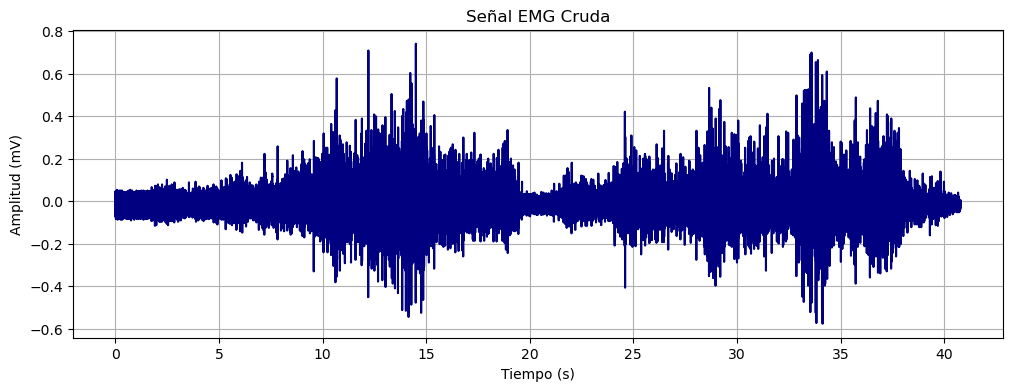

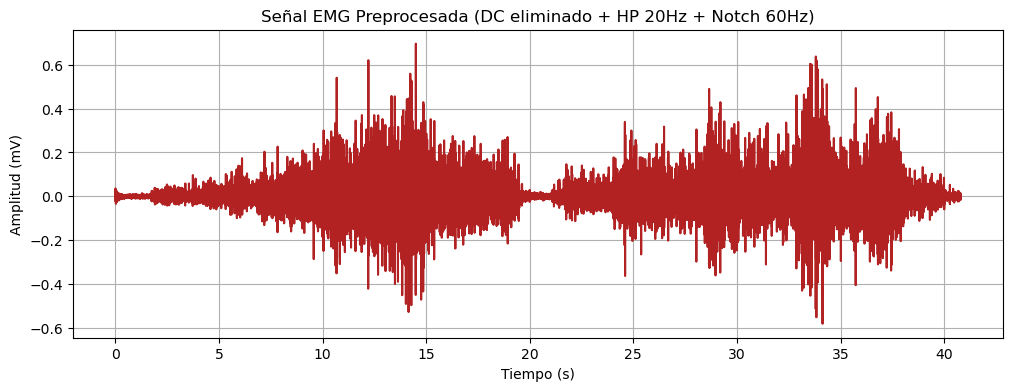

In [25]:
# === 7. Vector de tiempo ===
t = np.arange(len(EMG_clean)) / fs  # Tiempo en segundos 

# === 8. Graficar señal cruda ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_mV, color='navy')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Cruda")
plt.grid(True)
plt.show()

# === Graficar señal preprocesada (DC eliminado + HP + Notch) ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_clean, color='firebrick')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Preprocesada (DC eliminado + HP 20Hz + Notch 60Hz)")
plt.grid(True)
plt.show()

## 🟠 7. Rectificación y cálculo de envolvente
---
- La señal EMG se rectifica para eliminar valores negativos, preservando la magnitud de la actividad muscular.  
- La envolvente se calcula mediante un filtro pasa-bajo de 5 Hz, lo que permite estimar la amplitud general de la actividad muscular y visualizar patrones de reclutamiento de unidades motoras.  
- Se muestran ambos resultados para análisis comparativo.

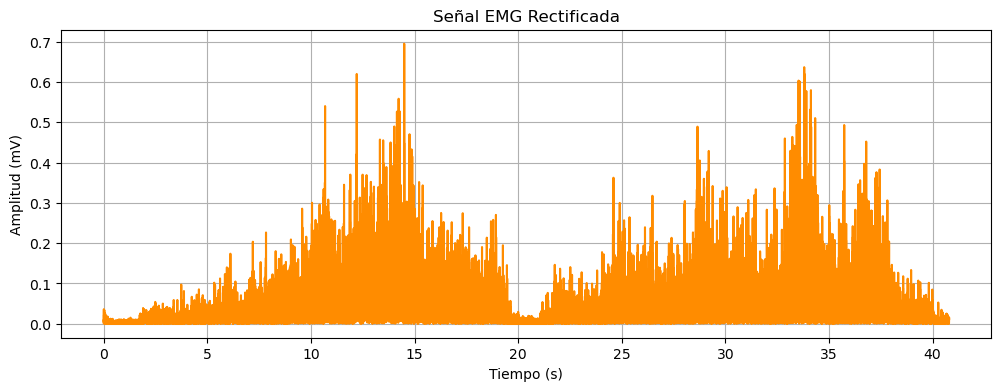

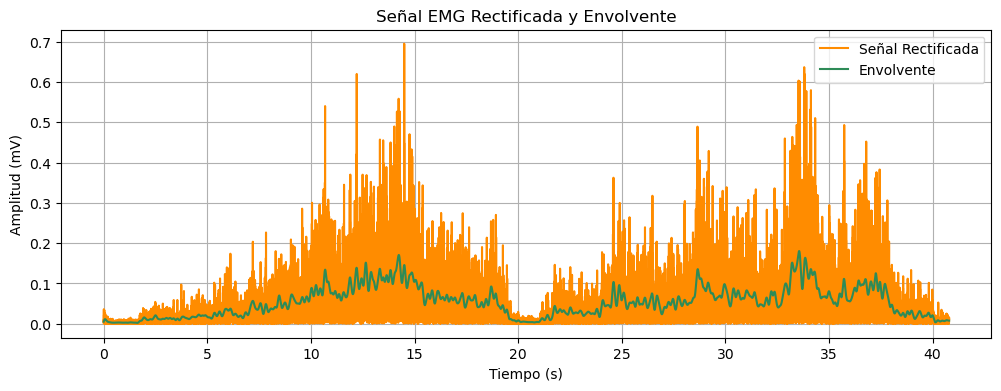

In [26]:
# === 9. Rectificación de la señal ===
EMG_rect = np.abs(EMG_clean)  # Valor absoluto para eliminar negativas
plt.figure(figsize=(12,4))
plt.plot(t, EMG_rect, color='darkorange')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Rectificada")
plt.grid(True)
plt.show()

# === 10. Calcular envolvente con filtro pasa-bajo 5 Hz ===
fc_env = 5  # Frecuencia de corte para suavizar la señal
b_env, a_env = signal.butter(4, fc_env/(fs/2), btype='low')
EMG_envelope = signal.filtfilt(b_env, a_env, EMG_rect)

plt.figure(figsize=(12,4))
plt.plot(t, EMG_rect, color='darkorange', label='Señal Rectificada')
plt.plot(t, EMG_envelope, color='seagreen', label='Envolvente')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Rectificada y Envolvente")
plt.legend()
plt.grid(True)
plt.show()


## 📊 8. Densidad espectral de potencia (PSD)
---
Se calcula la PSD de la señal preprocesada utilizando el método de Welch.  
Se visualiza en dB para analizar la distribución de energía en diferentes frecuencias.

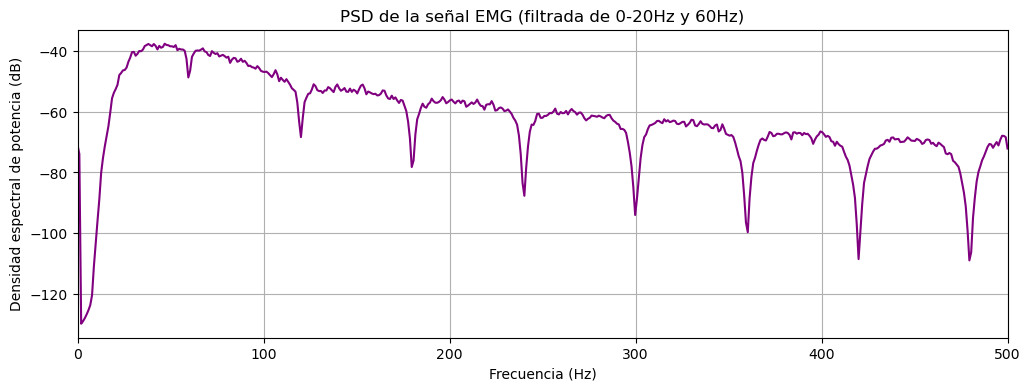

Frecuencias de picos detectados (Hz): [ 30.2734375  33.203125   38.0859375  41.015625   43.9453125  46.875
  50.78125    52.734375   54.6875     64.453125   67.3828125  72.265625
  75.1953125  78.125      81.0546875  83.984375   87.890625   89.84375
  92.7734375  96.6796875 101.5625    106.4453125 109.375     112.3046875
 126.953125  130.859375  132.8125    134.765625  139.6484375 143.5546875
 146.484375  148.4375    153.3203125 156.25      160.15625   164.0625
 168.9453125 170.8984375 173.828125  190.4296875 196.2890625 201.171875
 205.078125  207.03125   214.84375   222.65625  ]


In [27]:
# === 11. PSD (densidad espectral de potencia) en dB usando Welch ===
f_psd, Pxx = welch(EMG_clean, fs=fs, nperseg=1024)  # PSD de la señal filtrada
Pxx_dB = 10 * np.log10(Pxx)  # Convertir a dB

# === Detectar picos en la PSD (opcional) ===
peaks, _ = find_peaks(Pxx_dB, height=np.mean(Pxx_dB)+6)

# === Graficar PSD en dB ===
plt.figure(figsize=(12,4))
plt.plot(f_psd, Pxx_dB, color='purple')  # Solo línea de PSD
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral de potencia (dB)")
plt.title("PSD de la señal EMG (filtrada de 0-20Hz y 60Hz)")
plt.xlim(0, 500)
plt.grid(True)
plt.show()

# === Mostrar frecuencias de picos detectados ===
print("Frecuencias de picos detectados (Hz):", f_psd[peaks])
